<div style="text-align: center; background-color: #0A6EBD; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  Lab 02 - TRỰC QUAN HOÁ DỮ LIỆU 📌
</div>

<div style="text-align: center; background-color: #5A96E3; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  Giai đoạn 3 - Data Modelling 📌
</div>

### Nhập các thư viện cần thiết

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from datetime import datetime, date

from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings

warnings.simplefilter('ignore')

### Đọc dữ liệu

In [2]:
data = pd.read_csv('./data/Water_Cleaner_2.csv', parse_dates=['Date'], date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d'))
data = data.iloc[:, :-3]

# Modelling 

***Time Series*** có thể là `Đơn biến(Univariate)` hoặc `Đa biến(Multivariate)`:
- **Univariate Time Series:** Chỉ có một biến phụ thuộc vào thời gian. 
- **Multivariate Time Series:** Có nhiều biến phụ thuộc vào thời gian. 

Dữ liệu trong được sử dụng trong Lab này là Multivariable Time Series Data. 

$\rightarrow$ Dựa theo mục đích của tập dữ liệu này, **target** đã được chọn trong `1.0_Preprocessing` là ***Depth_to_Groundwater***, tức dự đoán mức nước ngầm để có thể chuẩn bị biện pháp bảo vệ nguồn nước.

$\rightarrow$ Có thể chuyển đổi **Multivariable Time Series Data** $\rightarrow$ **Univariable Time Series Data**

### Phương pháp

📌 Sử dụng ***Kiểm định chéo - Cross Validation***, giúp:
- *Đảm bảo tính khách quan của đánh giá*.
- *Mô phỏng quá trình dự báo thực tế*.

In [3]:
from sklearn.model_selection import TimeSeriesSplit

SPLITS = 3

X = data.Date
y = data.Depth_to_Groundwater

fold = TimeSeriesSplit(n_splits=SPLITS)

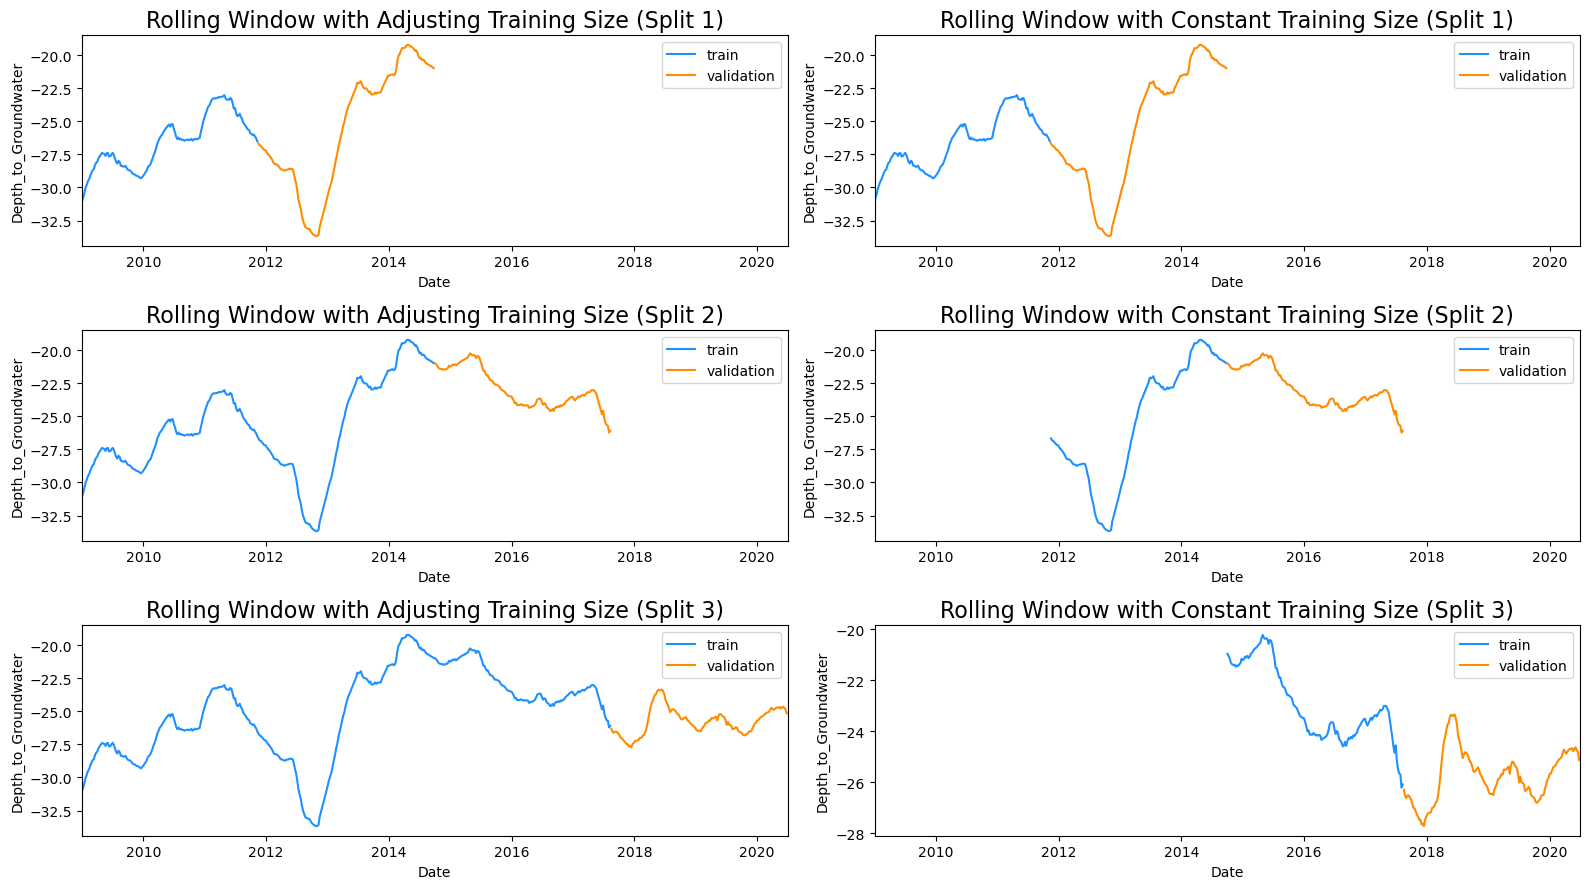

In [4]:
f, ax = plt.subplots(nrows=SPLITS, ncols=2, figsize=(16, 9))

for i, (train_index, valid_index) in enumerate(fold.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    sns.lineplot(x= X_train, y= y_train, ax=ax[i,0], color='dodgerblue', label='train')
    sns.lineplot(x= X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
                 y= y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
                 ax=ax[i,1], color='dodgerblue', label='train')

    for j in range(2):
        sns.lineplot(x= X_valid, y= y_valid, ax=ax[i, j], color='darkorange', label='validation')
    
    ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
    ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)

for i in range(SPLITS):
    ax[i, 0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    ax[i, 1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

plt.tight_layout()
plt.show()

$\rightarrow$ **Ý tưởng** của biểu đồ này là để hiểu nhóm đang sử dụng tập huấn luyện và kiểm tra nào để phù hợp với mô hình trong mỗi lần lặp.

### Chuẩn bị dữ liệu
Nhóm sẽ có `2` cách chuẩn bị dữ liệu để áp dụng cho các cách mô hình hóa khác nhau.

***Cách 1:***

`Chia dữ liệu theo quý` để có thể dự đoán, lập kế hoạch và quyết định chuẩn bị một cách tốt nhất.

- Dữ liệu kéo dài từ `1-1-2009` đến `25-6-2020`, tức `46 quý`.

- Sử dụng quý cuối - `46`, tức quý 2 thuộc năm 2020 để làm `tập test`.

- Phần còn lại sử dụng là `tập train` cho model.

In [5]:
df1 = data.copy()
df1['quarter'] = pd.PeriodIndex(df1['Date'], freq='Q')
df1['quarter_idx'] = (df1['quarter'] != df1['quarter'].shift(1)).cumsum()

target = 'Depth_to_Groundwater'
features = [feature for feature in df1.columns if feature != target]

N_SPLITS = 46

# Tập train không bao gồm quý cuối cùng
X = df1[df1.quarter_idx < N_SPLITS][features]
y = df1[df1.quarter_idx < N_SPLITS][target]

# Tập test là quý cuối - 46
X_test = df1[df1.quarter_idx == N_SPLITS][features].reset_index(drop=True)
y_test = df1[df1.quarter_idx == N_SPLITS][target].reset_index(drop=True)


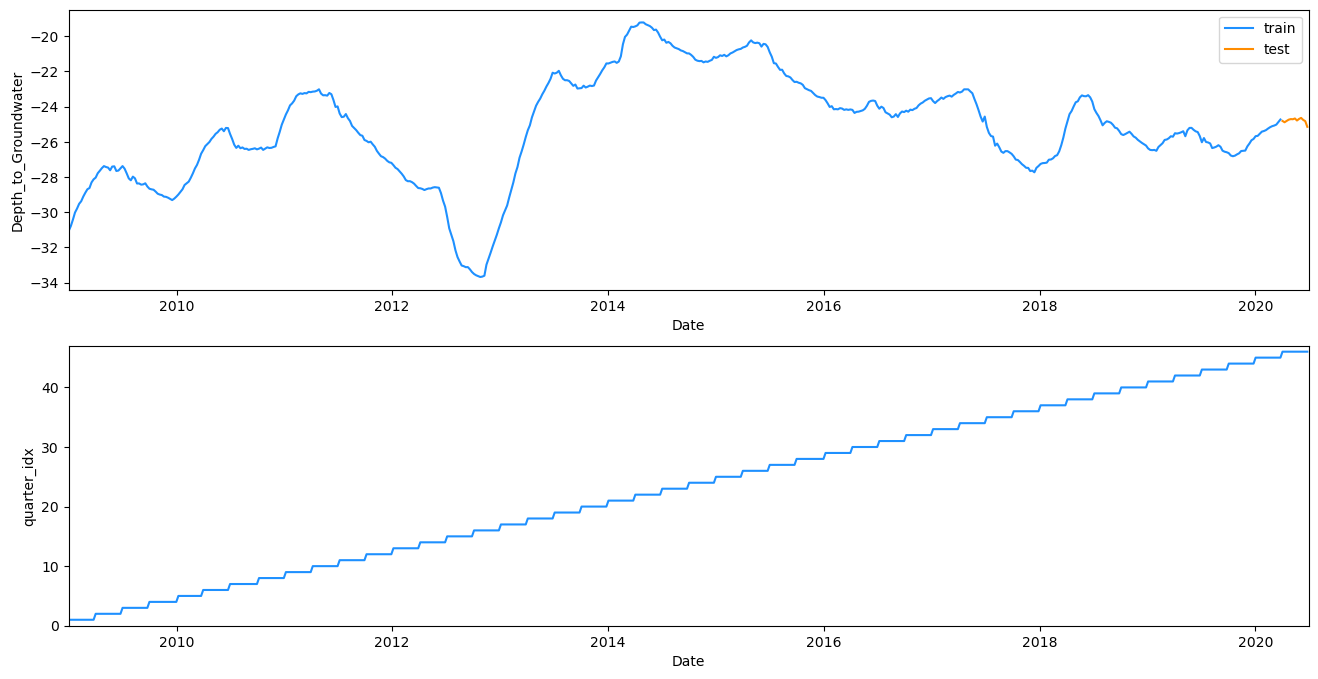

In [6]:
folds = np.linspace(0, N_SPLITS - 3, num=N_SPLITS - 2)

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

# Vẽ biểu đồ cho dữ liệu huấn luyện và kiểm tra
sns.lineplot(x=X['Date'], y=y, ax=ax[0], color='dodgerblue', label='train')
sns.lineplot(x=X_test['Date'], y=y_test, ax=ax[0], color='darkorange', label='test')

# Vẽ biểu đồ chỉ số quý theo thời gian
sns.lineplot(x=df1['Date'], y=df1['quarter_idx'], ax=ax[1], color='dodgerblue')

# Đặt giới hạn cho trục x và trục y
ax[0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
ax[1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
ax[1].set_ylim([0, N_SPLITS + 1])

plt.show()

**Hàm vẽ biểu đồ dựa trên Fold**

In [7]:
def plot_approach_evaluation(y_pred, score_mae, score_rsme, approach_name):
    f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))
    f.suptitle(approach_name, fontsize=16)
    
    # Vẽ dữ liệu huấn luyện, giá trị thực và giá trị dự đoán
    sns.lineplot(x=X.Date, y=y, ax=ax[0], color='dodgerblue', label='Training', linewidth=2)
    sns.lineplot(x=X_test.Date, y=y_test, ax=ax[0], color='gold', label='Ground Truth', linewidth=2)
    sns.lineplot(x=X_test.Date, y=y_pred, ax=ax[0], color='darkorange', label='Predicted', linewidth=2)
    
    # Thiết lập trục x và y cho biểu đồ dự đoán
    ax[0].set_xlim([date(2018, 6, 30), date(2020, 6, 30)])
    ax[0].set_ylim([-27, -23])
    ax[0].set_title(f'Prediction \n MAE: {mean_absolute_error(y_test, y_pred):.2f}, RSME: {math.sqrt(mean_squared_error(y_test, y_pred)):.2f}', fontsize=14)
    ax[0].set_xlabel('Date', fontsize=14)
    ax[0].set_ylabel('Depth to Groundwater P25', fontsize=14)
    
    # Vẽ biểu đồ loss (MAE và RSME)
    sns.lineplot(x=folds, y=score_mae,  color='gold', label='MAE', ax=ax[1])
    sns.lineplot(x=folds, y=score_rsme, color='indianred', label='RSME', ax=ax[1])
    
    # Thiết lập trục cho biểu đồ loss
    ax[1].set_title('Loss', fontsize=14)
    ax[1].set_xlabel('Fold', fontsize=14)
    ax[1].set_ylabel('Loss', fontsize=14)
    ax[1].set_ylim([0, 4])
    
    plt.subplots_adjust(hspace=0.5)
    plt.show()

***Cách 2:***
`Chia dữ liệu theo tỉ lệ` 85 & 15 - cách chia dữ liệu thường thấy, trong đó:
- 85% cho tập `train`.
- 15% cho tập `test`.

In [20]:
features = [
    'Rainfall',
    'Temperature',
    'Drainage_Volume',
    'River_Hydrometry',
]

target = ['Depth_to_Groundwater']

train_size = int(0.85 * len(data))

df2 = data[['Date'] + target + features].copy()
df2.columns = ['ds', 'y'] + features

# Chia dữ liệu thành tập huấn luyện và kiểm tra
train = df2.iloc[:train_size]
X2, y2 = train[['ds'] + features], train[['y']]

valid = df2.iloc[train_size:]
X2_valid, y2_valid = valid[['ds'] + features], valid[['y']]

📌 ***Đánh giá mô hình***
Hai chỉ số được sử dụng để đánh giá hiệu suất dự báo là:
- **Mean Absolute Error (MAE)**: Giá trị tuyệt đối trung bình của sai số dự báo.

- **Root Mean Square Error (RMSE)**: Căn bậc hai của trung bình bình phương sai số dự báo.

Cả hai chỉ số này đều cho biết độ lệch giữa giá trị dự báo và giá trị thực tế. Chỉ số càng nhỏ thì mô hình dự báo càng tốt.

## 1. Models for Univariate Time Series - Mô hình hóa Đơn biến

- ***Stochastic Models - Mô hình ngẫu nhiên:***
    - *Naive Approach*
    - *Exponential Smoothing*
    - *ARIMA*
    - *Prophet*

- ***Deep Learning - Học sâu:***
    - *LSTM*

### 1.1. Naive Approach

- Là một phương pháp **dự báo cơ bản** và **không phức tạp**. 
   - Phương pháp này thường dựa trên các **giả định đơn giản** và **không sử dụng các mô hình phức tạp hoặc các thuật toán phức tạp** để đưa ra dự đoán.

- ***Một số ứng dụng:***
   - **Dự báo chuỗi thời gian**:
      - *Naive Method*
      - *Seasonal Naive Method*
   
   - **Phân loại**: 
      - *Naive Bayes Classifier*

   - **Phân tích dữ liệu**

- ***Ưu điểm và Hạn chế của Naive Approach***
   - **Ưu điểm**:
      - Đơn giản và dễ hiểu: Dễ triển khai và giải thích.
      - Nhanh và hiệu quả: Yêu cầu ít tài nguyên tính toán.
      - Cơ sở so sánh: Cung cấp một đường cơ sở để so sánh với các mô hình phức tạp hơn.

   - **Hạn chế**:
      - Độ chính xác thấp: Do các giả định đơn giản, nó thường không chính xác như các mô hình phức tạp hơn.
      - Không linh hoạt: Khó điều chỉnh và cải tiến để phù hợp với các dữ liệu phức tạp hoặc có cấu trúc không rõ ràng.

📌 Như mục tiêu, để dự đoán giá trị **Depth_to_Groundwater**, tức dự đoán mức nước ngầm theo chuỗi thời gian. 

$\rightarrow$ Phương pháp được sử dụng là: ***Naive Method***

- Giả định rằng giá trị dự báo cho kỳ tiếp theo bằng giá trị của kỳ hiện tại hoặc kỳ trước đó.

- Công thức: $\hat{y}_t+1 = y_t$
​
  - Trong đó:
    - $\hat{y}_t+1$ là giá trị dự báo cho kỳ. 
    - $y_t$ là giá trị quan sát ở kỳ.

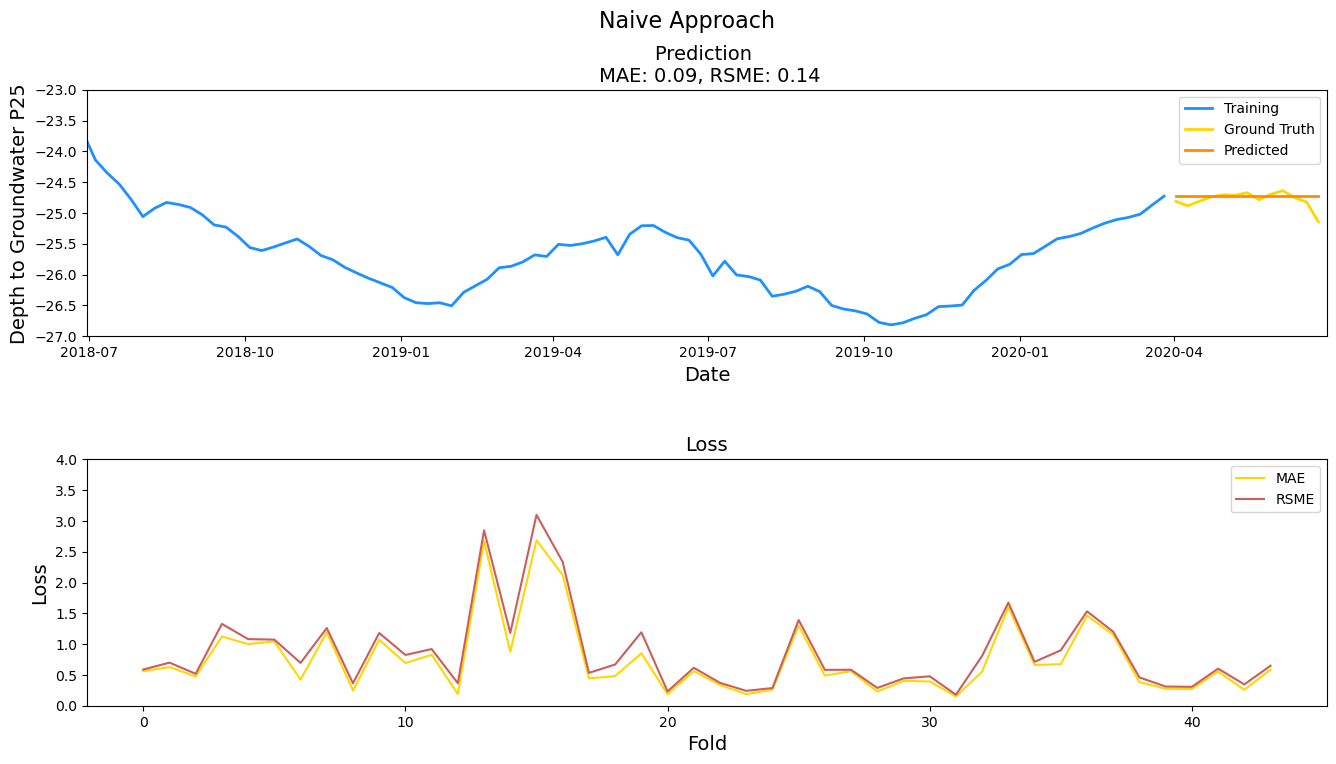

In [9]:
score_mae = []
score_rsme = []

for valid_quarter_id in range(2, N_SPLITS):
    train_index = df1[df1.quarter_idx < valid_quarter_id].index
    valid_index = df1[df1.quarter_idx == valid_quarter_id].index

    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    # Dự báo theo phương pháp Naive
    y_valid_pred = pd.Series(np.full(len(y_valid), y_train.iloc[-1]))
    
    score_mae.append(mean_absolute_error(y_valid, y_valid_pred))
    score_rsme.append(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))

y_pred = pd.Series(np.full(len(X_test), y.iloc[-1]))

plot_approach_evaluation(y_pred, score_mae, score_rsme, 'Naive Approach')

**Nhận xét:**

- ***Biểu đồ dự đoán - Dự đoán Naive Approach:***
    - Đường dự đoán gần như là *một đường ngang*, thể hiện đặc tính của mô hình Naive Approach.
    - `MAE (0.09)` và `RMSE (0.14)` tương đối thấp, cho thấy sai số dự báo trung bình là khá nhỏ. Tuy nhiên, các chỉ số này có thể bị ảnh hưởng bởi các biến động lớn trong một số khoảng thời gian nhất định.
    - Điều này làm cho mô hình *không bắt được xu hướng hoặc biến động trong dữ liệu*, dẫn đến các dự đoán không phản ánh đúng sự biến động của dữ liệu thực tế.

- ***Biểu đồ loss - Loss (MAE và RSME):***
    - Biểu đồ mất mát (loss) và sai số (MAE, RMSE) cho thấy sự biến động khá lớn theo từng fold trong quá trình kiểm định chéo (cross-validation). Điều này có thể là do dữ liệu có tính chất *không ổn định* hoặc mô hình chưa đủ phức tạp để nắm bắt hết các đặc điểm của dữ liệu.
    - Các đỉnh cao trong biểu đồ mất mát và sai số thường tương ứng với các thời điểm mà mô hình dự báo kém chính xác hơn, như đã thấy trong biểu đồ trên.

**Đánh giá tổng quan:**
- Mô hình Naive Approach rất đơn giản và dễ triển khai, nhưng thường không đạt hiệu quả cao trong việc dự đoán dữ liệu thời gian vì nó không bắt được xu hướng và biến động trong dữ liệu.

- Kết quả từ biểu đồ cho thấy mô hình Naive Approach chỉ hữu ích trong các trường hợp rất đơn giản hoặc làm baseline để so sánh với các mô hình phức tạp hơn.


### 1.2. ARIMA

***ARIMA*** **(Autoregressive Integrated Moving Average - Trung bình di động tích hợp tự hồi quy)** được sử dụng để *phân tích* và *dự báo dữ liệu chuỗi thời gian*, và một trong những khía cạnh quan trọng mà nó mô tả chính là *tính tự tương quan* trong dữ liệu.

📌 ***Tính tự tương quan (Autocorrelation)*** là mối quan hệ giữa các giá trị của một chuỗi thời gian tại các thời điểm khác nhau. Nói cách khác, nó đo lường mức độ mà giá trị hiện tại của chuỗi thời gian phụ thuộc vào các giá trị quá khứ của nó.

$$
y_t = c + α_1 y_{t-1} + ... + α_p y_{t-p} + ε_t = c + \sum_{i=1}^{p} α_i y_{t-i} + ε_t -> p
$$

Mô hình này gồm **3 thành phần** chính:
- **Tự hồi quy (AR)**: Sử dụng các giá trị quá khứ của chuỗi thời gian để dự đoán giá trị hiện tại, nắm bắt các mối quan hệ tuyến tính giữa các quan sát.
    - Phần này biểu diễn mối quan hệ tuyến tính giữa giá trị hiện tại của chuỗi thời gian ($y_t$) và các giá trị quá khứ của nó ($y_{t−1}, y_{t_2}, \dots, y_{t−p}​$).
    - Công thức:
    $$
    y_t = c + \alpha_1 y_{t-1} + ... + \alpha_p y_{t-p} + \epsilon_t = c + \sum_{i=1}^{p} \alpha_i y_{t-i} + \epsilon_t \longrightarrow p
    $$
    - Trong đó:
        - $y_t$: Giá trị của chuỗi thời gian tại thời điểm $t$.
        - $c$: Hằng số.
        - $\alpha_1, \dots, \alpha_p$: Các hệ số của mô hình AR.
        - $p$: Bậc của mô hình AR (số lượng giá trị quá khứ được sử dụng).
        - $\epsilon_t$: Sai số ngẫu nhiên tại thời điểm $t$.

- **Tích hợp (I)**: Làm cho chuỗi thời gian trở nên ổn định bằng cách lấy hiệu số giữa các quan sát liên tiếp, loại bỏ xu hướng hoặc các mẫu không ổn định khác.
    - Phần này được sử dụng để làm cho chuỗi thời gian trở nên ổn định bằng cách lấy hiệu số giữa các giá trị liên tiếp.
    - Công thức:
    $$
    \Delta d y_t = y_t - y_{t-d} \longrightarrow d
    $$
    - Trong đó:
        - $\Delta d$: Toán tử sai phân bậc $d$.
        - $d$: Bậc của thành phần tích hợp (số lần lấy hiệu số)

- **Trung bình di động (MA)**: Sử dụng các giá trị quá khứ của sai số dự báo để cải thiện độ chính xác của dự báo, nắm bắt các mối quan hệ ngắn hạn và ngẫu nhiên.
    - Phần này biểu diễn mối quan hệ giữa giá trị hiện tại của chuỗi thời gian ($y_t$) và các giá trị quá khứ của sai số dự báo ($\epsilon_{t−1}, \epsilon_{t_2}, \dots, \epsilon_{t−p}​$).
    - Công thức:
    $$
    y_t = c + \epsilon_t + \beta_1 \epsilon_{t-1} + ... + \beta_q \epsilon_{t-q} = c + \epsilon_t \sum_{i=1}^{q} \beta_i \epsilon_{t-i} + \longrightarrow q
    $$
    - Trong đó:
        - $y_t$: Giá trị của chuỗi thời gian tại thời điểm $t$.
        - $c$: Hằng số. 
        - $\beta_1, \dots, \beta_p$: Các hệ số của mô hình AR.
        - $q$: Bậc của mô hình MA (số lượng giá trị quá khứ của sai số dự báo được sử dụng).
        - $\epsilon_t$ : Sai số ngẫu nhiên tại thời điểm $t$.

$\implies$ **Công thức tổng quát của mô hình ARIMA($p,d,q$):**
$$
y_t = c + \alpha_1 y_{t-1} + ... + \alpha_p y_{t-p} + \epsilon_t + \beta_1 \epsilon_{t-1} + ... + \beta_q \epsilon_{t-q}
$$

- Trong đó:
    - $p$: Số bậc của thành phần **tự hồi quy (AR)**.
    - $d$: Số bậc của thành phần **tích hợp (I)**.
    - $q$: Số bậc của thành phần **trung bình di động (MA)**

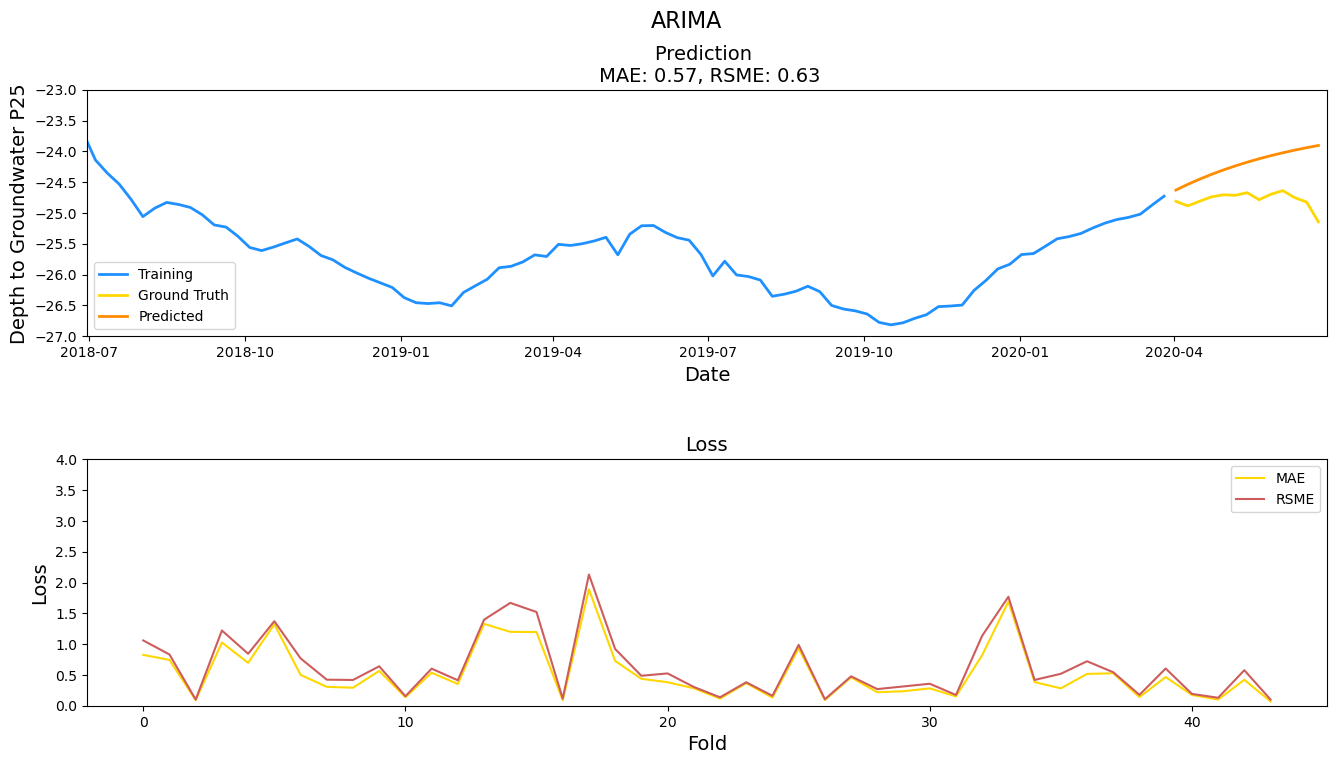

In [10]:
from statsmodels.tsa.arima.model import ARIMA

score_mae = []
score_rsme = []

for fold, valid_quarter_id in enumerate(range(2, N_SPLITS)):
    train_index = df1[df1.quarter_idx < valid_quarter_id].index
    valid_index = df1[df1.quarter_idx == valid_quarter_id].index

    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    # Huấn luyện mô hình với Vector Auto Regression (VAR)
    model = ARIMA(y_train, order=(1,1,1))
    model_fit = model.fit()
    
    y_valid_pred = model_fit.predict(valid_index[0], valid_index[-1])

    score_mae.append(mean_absolute_error(y_valid, y_valid_pred))
    score_rsme.append(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))

model = ARIMA(y, order=(1,1,1))
model_fit = model.fit()

y_pred = model_fit.predict(y.index[-1]+1, y.index[-1] + len(y_test)).reset_index(drop=True)
plot_approach_evaluation(y_pred, score_mae, score_rsme, 'ARIMA')

**Nhận xét:**
- ***Biểu đồ dự đoán***
    - **Tổng quan:** Dự đoán (Predicted, đường màu đỏ) có vẻ hơi lệch so với giá trị thực tế (Ground Truth, đường màu vàng) ở một số điểm, đặc biệt là vào cuối giai đoạn dự báo.
    
    - **Sai số:** Các chỉ số MAE (Mean Absolute Error) và RMSE (Root Mean Square Error) lần lượt là `0.57` và `0.63`, cho thấy sai số dự báo không quá lớn, nhưng cũng không phải là quá nhỏ. Điều này có nghĩa là mô hình dự báo khá tốt, nhưng vẫn có thể cải thiện thêm.

- ***Biểu đồ loss***
    - **Tổng quan:** Cả hai chỉ số đều dao động khá nhiều, đặc biệt là ở những fold đầu tiên. Điều này cho thấy mô hình có thể không ổn định và cần được điều chỉnh thêm.

    - **Điểm đáng chú ý:** Có một điểm đáng chú ý là ở khoảng fold thứ 20, cả MAE và RMSE đều giảm xuống mức thấp nhất. Cho thấy mô hình đã tìm được một tập hợp tham số tốt hơn ở giai đoạn này.

$\longrightarrow$ **Nhận xét chung:** Mô hình ARIMA đã thể hiện khả năng dự báo khá tốt độ sâu của nước ngầm.

### 1.3. Prophet

Là một mô hình dự báo chuỗi thời gian nguồn mở được phát triển bởi **Facebook**. 
- Được thiết kế để dễ sử dụng và có khả năng xử lý các chuỗi thời gian có các đặc điểm phức tạp như xu hướng phi tuyến, tính thời vụ và các ngày lễ.

- ***Các tính năng chính***:
    - **Dễ sử dụng**: Prophet cung cấp một giao diện đơn giản và trực quan, cho phép người dùng xây dựng các mô hình dự báo một cách nhanh chóng và dễ dàng.

    - **Tính linh hoạt**: Prophet có thể xử lý các chuỗi thời gian có các đặc điểm khác nhau, bao gồm cả xu hướng phi tuyến, tính thời vụ và các ngày lễ.
    
    - **Khả năng mở rộng**: Prophet có thể được sử dụng để dự báo cả dữ liệu ngắn hạn và dài hạn.
    
    - **Tính minh bạc**h: Prophet cung cấp các công cụ trực quan để giúp người dùng hiểu rõ hơn về mô hình dự báo và các yếu tố ảnh hưởng đến dự báo.


- ***Cách hoạt động***: Prophet sử dụng một **mô hình cộng (additive model)** để phân tách chuỗi thời gian thành các thành phần khác nhau:
    - **Xu hướng (trend)**: Mô tả sự thay đổi chung của chuỗi thời gian theo thời gian.
    - **Tính thời vụ (seasonality)**: Mô tả các mẫu lặp lại theo chu kỳ trong chuỗi thời gian, chẳng hạn như theo ngày, tuần, tháng hoặc năm.
    - **Các ngày lễ (holidays)**: Mô tả các sự kiện đặc biệt có thể ảnh hưởng đến chuỗi thời gian, chẳng hạn như các ngày lễ hoặc các sự kiện lớn.

$\longrightarrow$ Prophet sử dụng các phương pháp hồi quy và các hàm đặc biệt để mô hình hóa từng thành phần này. Sau đó, nó kết hợp các thành phần này lại để tạo ra dự báo cuối cùng.

13:19:20 - cmdstanpy - INFO - Chain [1] start processing
13:19:20 - cmdstanpy - INFO - Chain [1] done processing
13:19:21 - cmdstanpy - INFO - Chain [1] start processing
13:19:21 - cmdstanpy - INFO - Chain [1] done processing
13:19:21 - cmdstanpy - INFO - Chain [1] start processing
13:19:22 - cmdstanpy - INFO - Chain [1] done processing
13:19:22 - cmdstanpy - INFO - Chain [1] start processing
13:19:22 - cmdstanpy - INFO - Chain [1] done processing
13:19:22 - cmdstanpy - INFO - Chain [1] start processing
13:19:23 - cmdstanpy - INFO - Chain [1] done processing
13:19:23 - cmdstanpy - INFO - Chain [1] start processing
13:19:24 - cmdstanpy - INFO - Chain [1] done processing
13:19:24 - cmdstanpy - INFO - Chain [1] start processing
13:19:24 - cmdstanpy - INFO - Chain [1] done processing
13:19:24 - cmdstanpy - INFO - Chain [1] start processing
13:19:25 - cmdstanpy - INFO - Chain [1] done processing
13:19:25 - cmdstanpy - INFO - Chain [1] start processing
13:19:25 - cmdstanpy - INFO - Chain [1]

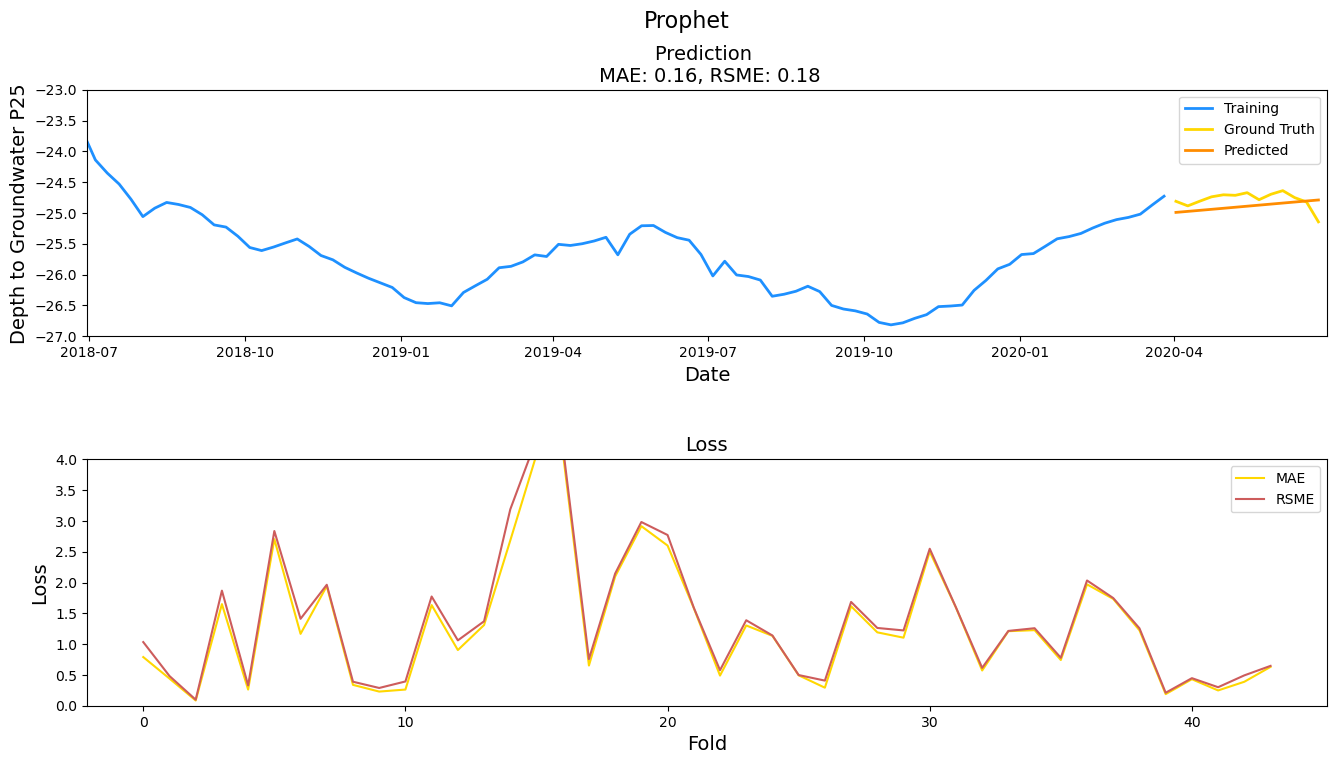

In [11]:
from prophet import Prophet

score_mae = []
score_rmse = []

for valid_quarter_id in range(2, N_SPLITS):
    train_index = df1[df1.quarter_idx < valid_quarter_id].index
    valid_index = df1[df1.quarter_idx == valid_quarter_id].index

    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]

    # Kết hợp dữ liệu từ X và y cho Prophet
    train_data = pd.DataFrame({'ds': X_train['Date'], 'y': y_train.values})
    valid_data = pd.DataFrame({'ds': X_valid['Date'], 'y': y_valid.values})

    # Huấn luyện mô hình Prophet
    model = Prophet()
    model.fit(train_data)

    future = valid_data[['ds']]
    forecast = model.predict(future)
    y_valid_pred = forecast['yhat'].values

    score_mae.append(mean_absolute_error(y_valid, y_valid_pred))
    score_rmse.append(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))

train_data = pd.DataFrame({'ds': X['Date'], 'y': y.values})
model = Prophet()
model.fit(train_data)

future = pd.DataFrame({'ds': pd.date_range(start=X['Date'].iloc[-1], periods=len(y_test) + 1, freq='D')[1:]})
forecast = model.predict(future)
y_pred = forecast['yhat'].values

plot_approach_evaluation(y_pred, score_mae, score_rmse, 'Prophet')


**Nhận xét:**
- ***Khả năng dự đoán của mô hình:***
    - Nhìn chung, mô hình Prophet thể hiện khả năng dự đoán khá tốt về độ sâu mực nước ngầm. Đường dự đoán (màu cam) bám sát gần với giá trị thực tế (màu vàng) trong khoảng thời gian 4/2020 đến hết.
    - Tuy nhiên, có một số thời điểm mô hình dự đoán chưa thực sự chính xác, đặc biệt là vào cuối năm 2019 và đầu năm 2020, khi đường dự đoán có xu hướng lệch lên trên so với giá trị thực tế.

- ***Hiệu suất của mô hình:***
    - Các độ đo MAE (Mean Absolute Error) và RMSE (Root Mean Square Error) đều khá nhỏ (lần lượt là `0.16` và `0.18`), cho thấy sai số dự đoán của mô hình không lớn.
    - Biểu đồ Loss (mất mát) ở phía dưới cho thấy quá trình huấn luyện mô hình diễn ra khá ổn định. Giá trị Loss giảm dần theo số lần lặp (Fold), và các đường MAE và RMSE cũng có xu hướng giảm, thể hiện mô hình đang học và cải thiện khả năng dự đoán qua từng lần lặp.


$\rightarrow$ **Nhận xét chung:**
- Mô hình Prophet cho thấy tiềm năng tốt trong việc dự đoán độ sâu mực nước ngầm. Tuy nhiên, vẫn cần cải thiện độ chính xác của mô hình, đặc biệt là trong việc dự đoán các biến động đột ngột của mực nước.

- Việc phân tích thêm các yếu tố ảnh hưởng đến mực nước ngầm (như lượng mưa, hoạt động khai thác nước,...) có thể giúp cải thiện hiệu suất của mô hình.

- Việc tinh chỉnh các siêu tham số của mô hình Prophet cũng có thể là một hướng tiếp cận để nâng cao khả năng dự đoán.

### 1.4. LSTM

Là một loại **mạng nơ-ron nhân tạo** đặc biệt, thuộc nhóm mạng nơ-ron hồi quy (**RNN - Recurrent Neural Network**). 
- LSTM được thiết kế để giải quyết vấn đề "quên lãng" của các RNN truyền thống, tức là khả năng ghi nhớ thông tin trong một khoảng thời gian dài.

- ***Cấu trúc***: LSTM bao gồm các đơn vị (cell) được kết nối với nhau theo chuỗi thời gian. Mỗi cell có `3` cổng chính:
    - **Cổng quên (Forget gate):** Quyết định thông tin nào cần được loại bỏ khỏi trạng thái cell.
    - **Cổng vào (Input gate):** Quyết định thông tin nào cần được thêm vào trạng thái cell.
    - **Cổng ra (Output gate):** Quyết định thông tin nào cần được xuất ra từ trạng thái cell.
    - Ngoài ra, LSTM còn có một trạng thái cell (cell state) để lưu trữ thông tin dài hạn.

- ***Ưu điểm và nhược điểm:***
    - **Ưu điểm:**
        - Khả năng ghi nhớ thông tin trong một khoảng thời gian dài.
        - Khả năng học các mô hình phức tạp trong dữ liệu tuần tự.
        - Ứng dụng rộng rãi trong nhiều lĩnh vực như xử lý ngôn ngữ tự nhiên, nhận dạng giọng nói, dự báo chuỗi thời gian, v.v.

    - **Nhược điểm:**
        - Độ phức tạp: Có cấu trúc phức tạp hơn so với các mô hình truyền thống, dẫn đến việc tốn nhiều thời gian và tài nguyên tính toán.
        - Dễ bị overfitting: Dễ bị overfitting nếu không được điều chỉnh cẩn thận, đặc biệt khi dữ liệu huấn luyện không đủ lớn hoặc có nhiễu.
        - Phụ thuộc vào dữ liệu: Phụ thuộc rất nhiều vào chất lượng và số lượng dữ liệu huấn luyện. 
        - Khó diễn giải: Là một **mô hình hộp đen - black box**.

In [12]:
from sklearn.preprocessing import MinMaxScaler

uni = df2[['ds', 'y']].copy()
uni_df = uni[['y']].values

scaler = MinMaxScaler(feature_range=(-1, 0))
scaled_data = scaler.fit_transform(uni_df)

In [13]:
# Xác định rolling window
look_back = 52
lstm_train, lstm_test = scaled_data[:train_size-look_back,:], scaled_data[train_size-look_back:,:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        a = dataset[i-look_back:i, 0]
        X.append(a)
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

X_lstm_train, y_lstm_train = create_dataset(lstm_train, look_back)
X_lstm_test, y_lstm_test = create_dataset(lstm_test, look_back)

# reshape đầu vào thành [samples, time steps, features]
X_lstm_train = np.reshape(X_lstm_train, (X_lstm_train.shape[0], 1, X_lstm_train.shape[1]))
X_lstm_test = np.reshape(X_lstm_test, (X_lstm_test.shape[0], 1, X_lstm_test.shape[1]))

In [14]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

#Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(X_lstm_train.shape[1], X_lstm_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(X_lstm_train, y_lstm_train, batch_size=1, epochs=5, validation_data=(X_lstm_test, y_lstm_test))

model.summary()

Epoch 1/5
406/406 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0270 - val_loss: 0.0092
Epoch 2/5
406/406 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0036 - val_loss: 0.0014
Epoch 3/5
406/406 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0032 - val_loss: 0.0046
Epoch 4/5
406/406 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0018 - val_loss: 5.7355e-04
Epoch 5/5
406/406 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0012 - val_loss: 3.8161e-04


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 128)         │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 431,195 (1.64 MB)

 Trainable params: 143,731 (561.45 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 287,464 (1.10 MB)

In [15]:
train_predict = model.predict(X_lstm_train)
test_predict = model.predict(X_lstm_test)

train_predict = scaler.inverse_transform(train_predict)
y_lstm_train = scaler.inverse_transform([y_lstm_train])

test_predict = scaler.inverse_transform(test_predict)
y_lstm_test = scaler.inverse_transform([y_lstm_test])

# Get the root mean squared error (RMSE) and MAE
score_rmse = np.sqrt(mean_squared_error(y_lstm_test[0], test_predict[:,0]))
score_mae = mean_absolute_error(y_lstm_test[0], test_predict[:,0])
print('RMSE: {}'.format(score_rmse))

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
RMSE: 0.2826973814634687


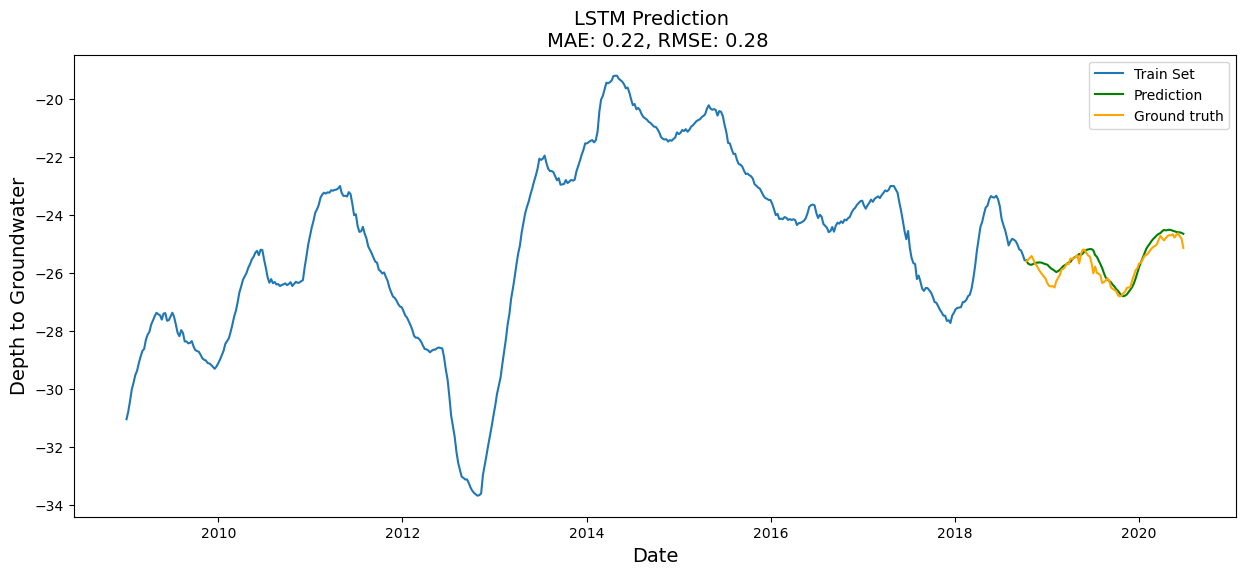

In [16]:
x_train_ticks = uni.head(train_size)['ds']
y_train_ticks = uni.head(train_size)['y']
x_test_ticks = uni.tail(len(df2) - train_size)['ds']

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

sns.lineplot(x=x_train_ticks, y=y_train_ticks, ax=ax, label='Train Set')
sns.lineplot(x=x_test_ticks, y=test_predict[:,0], ax=ax, color='green', label='Prediction')
sns.lineplot(x=x_test_ticks, y=y_lstm_test[0], ax=ax, color='orange', label='Ground truth')

ax.set_title(f'LSTM Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()

**Nhận xét:**
- Mô hình LSTM dự đoán khá tốt xu hướng chung của độ sâu mực nước ngầm trong tập dữ liệu huấn luyện (train set) và tập dữ liệu kiểm tra (prediction).

- Tuy nhiên, vẫn có sự sai khác giữa giá trị dự đoán và giá trị thực tế. Sai số này được thể hiện qua MAE (Mean Absolute Error) là `0.19 `và RMSE (Root Mean Square Error) là `0.24`.

- Trong giai đoạn từ 2019 đến 2020, mô hình có xu hướng dự đoán độ sâu mực nước ngầm lớn hơn so với thực tế.

$\longrightarrow$ Nhìn chung, mô hình LSTM đã thể hiện khả năng dự đoán khá tốt độ sâu mực nước ngầm, mặc dù vẫn còn một số sai số nhất định.

## 2. Models for Multivariate Time Series - Mô hình hóa Đa biến

### 2.1. Vector Auto Regression (VAR)

Là **mô hình hồi quy vectơ tự động**, là một mô hình thống kê được sử dụng để nắm bắt mối quan hệ và sự phụ thuộc lẫn nhau giữa nhiều biến số theo thời gian. 
- VAR là một dạng tổng quát của mô hình tự hồi quy (AR) truyền thống, cho phép phân tích đồng thời nhiều chuỗi thời gian.

- ***Công thức:***
$$
y_t = \alpha_1 y_{t-1} + \alpha_2 y_{t-2} + \dots + \alpha_p y_{t-p} + u_t
$$
- Trong đó:
    - $y_t$ là một vectơ chứa các giá trị của các biến số tại thời điểm $t$.
    - $\alpha_1, \alpha_2, \dots, \alpha_p$ là các ma trận hệ số mô tả ảnh hưởng của các giá trị quá khứ lên giá trị hiện tại.
    - $p$ là số lượng độ trễ (`lags`) được đưa vào mô hình.
    - $u_t$ là một vectơ chứa các nhiễu loạn ngẫu nhiên.

- ***Ứng dụng:*** Mô hình VAR được ứng dụng rộng rãi trong nhiều lĩnh vực, đặc biệt là kinh tế và tài chính, để:
    - **Dự báo:** VAR có thể được sử dụng để dự báo các giá trị tương lai của các biến số dựa trên mối quan hệ lịch sử của chúng.
    - **Phân tích xung lực - phản ứng (Impulse Response Analysis):** VAR cho phép đánh giá tác động của một cú sốc (shock) lên một biến số đối với các biến số khác trong hệ thống.
    - **Phân tích phương sai lỗi dự báo (Forecast Error Variance Decomposition):** VAR giúp xác định mức độ đóng góp của từng biến số vào sự biến động của các biến số khác.
    - **Kiểm định quan hệ nhân quả Granger:** VAR có thể được sử dụng để kiểm định xem liệu một biến số có ảnh hưởng nhân quả Granger đến một biến số khác hay không.

- ***Ưu điểm và nhược điểm:***
    - **Ưu điểm:**
        - Đơn giản và dễ sử dụng.
        - Không yêu cầu giả định chặt chẽ về mối quan hệ giữa các biến số.
        - Có thể nắm bắt được sự phụ thuộc động phức tạp giữa các biến số.

    - **Nhược điểm:**
        - Có thể gặp vấn đề về độ tin cậy nếu số lượng biến số quá lớn hoặc số lượng quan sát quá ít.
        - Không cung cấp thông tin về hướng nhân quả giữa các biến số.

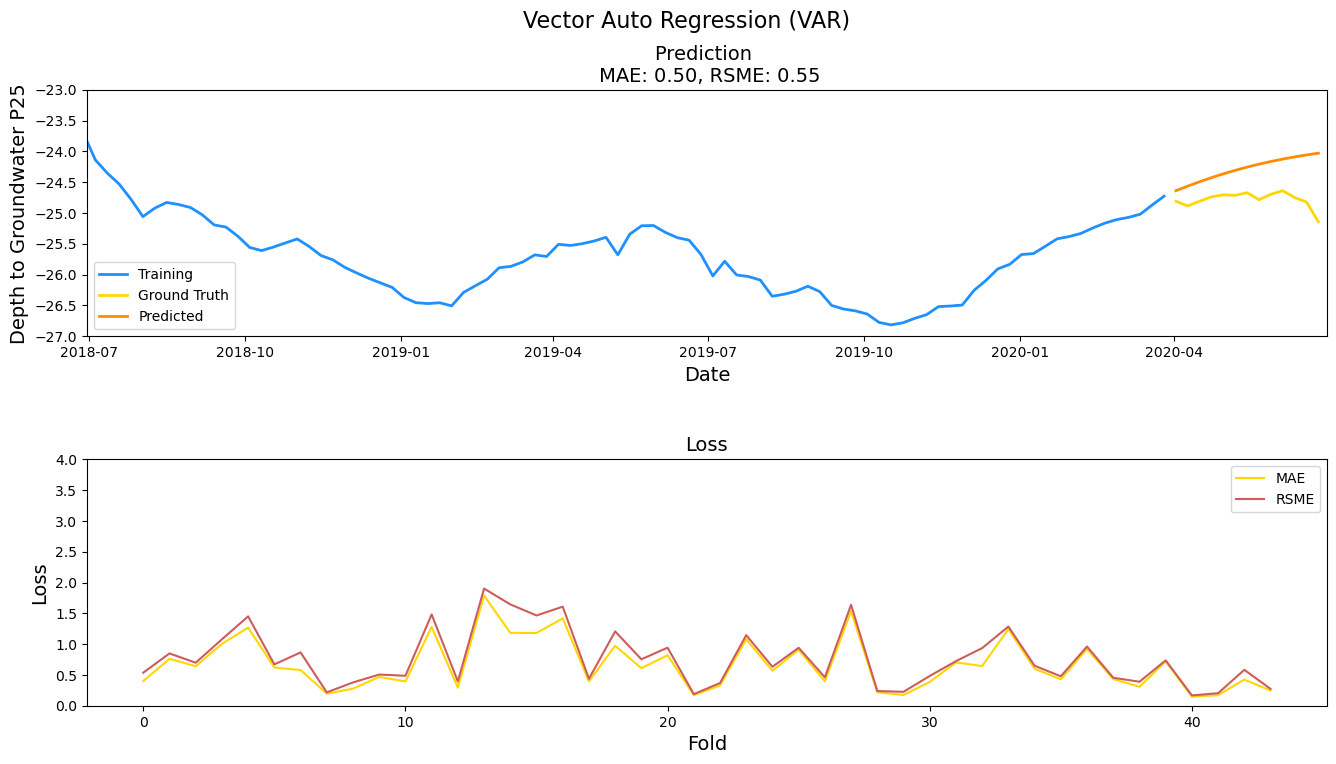

In [17]:
from statsmodels.tsa.api import VAR

score_mae = []
score_rsme = []

features = ['Temperature', 'Drainage_Volume', 'River_Hydrometry', 'Rainfall']

for fold, valid_quarter_id in enumerate(range(2, N_SPLITS)):
    train_index = df1[df1.quarter_idx < valid_quarter_id].index
    valid_index = df1[df1.quarter_idx == valid_quarter_id].index

    train_data = pd.concat([y.iloc[train_index], X.iloc[train_index][features]], axis=1)
    valid_data = pd.concat([y.iloc[valid_index], X.iloc[valid_index][features]], axis=1)
    
    # Huấn luyện mô hình với Vector Auto Regression (VAR)
    model = VAR(train_data)
    model_fit = model.fit()

    lag_order = model_fit.k_ar
    forecast_input = train_data.values[-lag_order:]
    y_valid_pred = model_fit.forecast(forecast_input, steps=len(valid_data))
    y_valid_pred = pd.Series(y_valid_pred[:, 0], index=valid_data.index)

    score_mae.append(mean_absolute_error(valid_data[target], y_valid_pred))
    score_rsme.append(math.sqrt(mean_squared_error(valid_data[target], y_valid_pred)))

full_data = pd.concat([y, X[features]], axis=1)
model = VAR(full_data)
model_fit = model.fit()

lag_order = model_fit.k_ar
forecast_input = full_data.values[-lag_order:]
y_pred = model_fit.forecast(forecast_input, steps=len(X_valid))
y_pred = pd.Series(y_pred[:, 0])

plot_approach_evaluation(y_pred, score_mae, score_rsme, 'Vector Auto Regression (VAR)')


**Nhận xét:**

- ***Biểu đồ dự đoán:***
    - **Tổng quan:** Dự đoán (Predicted, đường màu đỏ) có vẻ hơi lệch so với giá trị thực tế (Ground Truth, đường màu vàng), đặc biệt là vào cuối giai đoạn dự báo.
    - **Sai số:** Các chỉ số MAE (Mean Absolute Error) và RMSE (Root Mean Square Error) lần lượt là `0.50` và `0.55`, cho thấy sai số dự báo không quá lớn. Điều này có nghĩa là mô hình dự báo khá tốt, nhưng vẫn có thể cải thiện thêm.

- ***Biểu đồ loss:***
    - **Tổng quan:** Cả hai chỉ số đều dao động khá nhiều, đặc biệt là ở những fold đầu tiên. Cho thấy mô hình có thể không ổn định và cần được điều chỉnh thêm.
    - **Điểm đáng chú ý:** Có một điểm đáng chú ý là ở khoảng fold thứ 20, cả MAE và RMSE đều giảm xuống mức thấp nhất. Điều này có thể là một dấu hiệu cho thấy mô hình đã tìm được một tập hợp tham số tốt hơn ở giai đoạn này.

### 2.2. Multivariate Prophet

📌 Về bản chất, Multivariate Prophet mở rộng từ khả năng của Prophet để dự báo không chỉ một mà nhiều biến số phụ thuộc đồng thời, tận dụng mối quan hệ và tương tác giữa chúng.

- ***Cách hoạt động:***
    - **Tách biệt mô hình:** Multivariate Prophet hoạt động bằng cách xây dựng một mô hình Prophet riêng biệt cho từng biến số phụ thuộc.
    - **Tích hợp thông tin:** Các mô hình riêng biệt này sau đó được kết hợp lại, cho phép thông tin từ một biến số ảnh hưởng đến dự báo của các biến số khác. Điều này đạt được bằng cách sử dụng các biến số làm `regressors` (biến hồi quy) cho nhau.
    - **Dự báo đồng thời:** Cuối cùng, tất cả các mô hình được dự báo đồng thời, tạo ra dự báo đa biến nhất quán.

- ***Ưu điểm và nhược điểm:***
    - **Ưu điểm:**
        - Đơn giản và dễ sử dụng: Giao diện của Multivariate Prophet tương tự như Prophet, giúp việc học và sử dụng trở nên dễ dàng.
        - Tận dụng mối quan hệ: Khả năng kết hợp thông tin từ nhiều biến số giúp cải thiện độ chính xác của dự báo.
        - Linh hoạt: Có thể dễ dàng tùy chỉnh các tham số và thêm các regressors bên ngoài để phù hợp với từng trường hợp cụ thể.

    - **Nhược điểm:**
        - Giới hạn trong mô hình hóa tương tác: Multivariate Prophet có thể gặp khó khăn trong việc mô hình hóa các tương tác phức tạp giữa các biến số.
        - Yêu cầu dữ liệu đủ lớn: Để đảm bảo hiệu quả, cần có đủ dữ liệu để huấn luyện các mô hình riêng biệt.

📌 Multivariate Prophet sẽ không sử dụng Cross-Validation như Univariate Prophet vừa để giảm độ phức tạp vừa để thay đổi cách tiếp cận

In [19]:
X_valid

,Date,Temperature,Drainage_Volume,River_Hydrometry,Rainfall,quarter,quarter_idx
574,2020-01-02,4.485714,-23444.022857,2.585714,0.2,2020Q1,45
575,2020-01-09,3.557143,-26477.650286,2.500000,0.0,2020Q1,45
576,2020-01-16,5.428571,-29099.643429,2.471429,6.2,2020Q1,45
577,2020-01-23,7.642857,-29152.594286,2.471429,8.8,2020Q1,45
578,2020-01-30,10.842857,-29507.328000,2.428571,2.2,2020Q1,45
579,2020-02-06,7.900000,-28011.497143,2.414286,0.0,2020Q1,45
580,2020-02-13,8.785714,-27819.195429,2.428571,8.4,2020Q1,45
581,2020-02-20,9.185714,-28223.053714,2.400000,2.8,2020Q1,45
582,2020-02-27,9.042857,-28405.110857,2.728571,41.4,2020Q1,45
583,2020-03-05,9.142857,-28728.617143,2.900000,30.2,2020Q1,45


In [21]:
from prophet import Prophet

# Huấn luyện mô hình
model = Prophet()
model.add_regressor('Rainfall')
model.add_regressor('Temperature')
model.add_regressor('Drainage_Volume')
model.add_regressor('River_Hydrometry')

model.fit(train)

y_pred = model.predict(X2_valid)

score_mae = mean_absolute_error(y2_valid, y_pred['yhat'])
score_rmse = math.sqrt(mean_squared_error(y2_valid, y_pred['yhat']))

print('RMSE: {}'.format(score_rmse))

13:21:31 - cmdstanpy - INFO - Chain [1] start processing
13:21:32 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 0.995243537542998


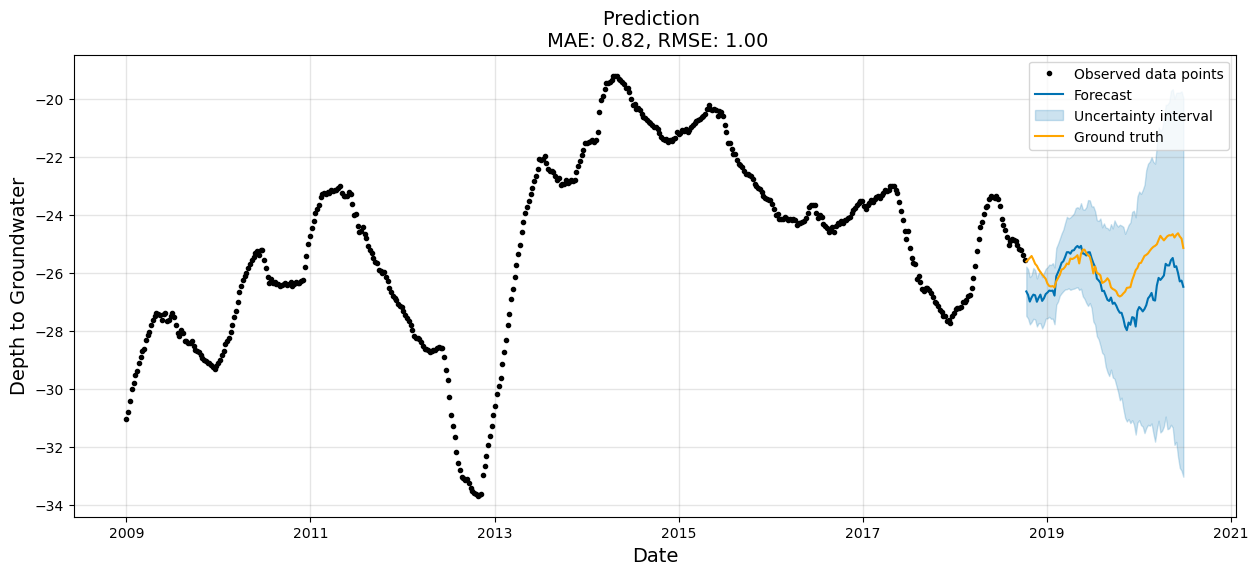

In [22]:
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model.plot(y_pred, ax=ax)
sns.lineplot(x=X2_valid['ds'], y=y2_valid['y'], ax=ax, color='orange', label='Ground truth')

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()

**Nhận xét:**
- ***Độ chính xác tổng thể:***
    - MAE (Mean Absolute Error) là `0.82` cho thấy sai số trung bình tuyệt đối giữa giá trị dự báo và giá trị thực tế là khá thấp.
    - RMSE (Root Mean Square Error) là `1.00` chỉ ra rằng độ lệch trung bình bình phương giữa dự báo và giá trị thực tế cũng không quá lớn.

- ***Khả năng bắt chước xu hướng:***
    - Dự báo (đường màu xanh) tương đối khớp với giá trị thực tế (đường màu vàng), cho thấy mô hình đã khá tốt trong việc bắt chước xu hướng chung của dữ liệu.
    - Mô hình dường như phản ánh được các biến động lớn và các chu kỳ theo mùa của dữ liệu.

- ***Khoảng không chắc chắn:***
    - Vùng màu xanh đại diện cho khoảng không chắc chắn của dự báo.
    - Độ rộng của khoảng không chắc chắn tăng dần theo thời gian, cho thấy sự không chắc chắn của dự báo tăng lên khi dự đoán càng xa về tương lai.

- ***Độ lệch giữa dự báo và thực tế:***
    - Mặc dù dự báo nhìn chung khớp với xu hướng thực tế, nhưng vẫn có một số giai đoạn mà dự báo lệch so với giá trị thực tế.
    - Sự khác biệt này có thể do các yếu tố ngẫu nhiên hoặc các yếu tố mà mô hình không bắt được.

$\longrightarrow$ **Đánh giá trực quan:** Nhìn chung, mô hình dự báo hoạt động tốt khi so sánh dự báo với giá trị thực tế, đặc biệt là trong các khoảng thời gian ngắn hạn. Tuy nhiên, độ rộng của khoảng không chắc chắn cho thấy mô hình có thể cần cải thiện để dự báo chính xác hơn trong các khoảng thời gian dài hạn.